In [176]:
!curl -O https://raw.githubusercontent.com/acen20/DNN-Labs/master/Datasets/ClaMP_Integrated-5184.csv
!wget -O encoder.pt https://github.com/acen20/DNN-Labs/raw/master/Lab4/encoder.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1253k  100 1253k    0     0  14.5M      0 --:--:-- --:--:-- --:--:-- 14.5M
--2021-12-05 17:32:19--  https://github.com/acen20/DNN-Labs/raw/master/Lab4/encoder.pt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/acen20/DNN-Labs/master/Lab4/encoder.pt [following]
--2021-12-05 17:32:20--  https://raw.githubusercontent.com/acen20/DNN-Labs/master/Lab4/encoder.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75445 (74K) [application/octe

In [177]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [178]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [179]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('ClaMP_Integrated-5184.csv')

## Preprocessing

In [180]:
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [181]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)

In [182]:
# Peak on dataset
df.head()

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,144,3,4,65535,184,256,4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,144,3,4,65535,184,184,4,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,144,3,4,65535,184,272,5,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,144,3,4,65535,184,184,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,144,3,4,65535,184,224,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [183]:
# Droping these columns due to their insignificance
df=df.drop(['NumberOfSections','CreationYear','e_cblp','e_cp','e_cparhdr','e_maxalloc'], axis=1)

In [184]:
df.shape

(5210, 64)

In [185]:
# Peak on the dataset
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,NoPacker,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,NoPacker,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,NoPacker,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,NoPacker,6.355626,0.702621,48128,5.545531,1,0


In [186]:
yes,no = df['class'].value_counts()

In [187]:
print(yes,no)

2722 2488


In [188]:
#No class has less instances

In [189]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
X = df.drop(['class'],axis=1)
y = df['class']

In [190]:
# Now check the features for the feature column "Packer_type". They are converted fr
df.head()

,e_sp,e_lfanew,FH_char0,FH_char1,FH_char2,FH_char3,FH_char4,FH_char5,FH_char6,FH_char7,FH_char8,FH_char9,FH_char10,FH_char11,FH_char12,FH_char13,FH_char14,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,OH_DLLchar0,OH_DLLchar1,OH_DLLchar2,OH_DLLchar3,OH_DLLchar4,OH_DLLchar5,OH_DLLchar6,OH_DLLchar7,OH_DLLchar8,OH_DLLchar9,OH_DLLchar10,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,sus_sections,non_sus_sections,packer,packer_type,E_text,E_data,filesize,E_file,fileinfo,class
0,184,256,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,8,0,1100288,225792,0,1069880,4096,1110016,0,1,1,4,0,0,0,5,1,1,1,1194954,3,1,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,6.603616,5.443362,1181520,6.627552,1,0
1,184,184,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,5,10,4096,2560,0,7680,4096,8192,1,1,1,4,0,0,0,4,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,3,0,18,5.205926,2.123522,7680,5.318221,0,0
2,184,272,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,27648,20480,0,28859,4096,32768,1,1,1,5,0,0,0,5,0,1,1,67688,2,1,0,1,0,0,0,0,0,0,0,0,1048576,4096,1048576,4096,1,1,4,0,18,6.238000,3.380859,57872,6.507758,1,0
3,184,184,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,9,0,0,87552,0,0,4096,4096,1,1,1,6,1,6,1,5,0,1,1,113668,2,1,0,1,0,1,0,0,0,0,0,0,1048576,4096,1048576,4096,1,0,1,0,18,0.000000,0.000000,95616,4.575092,1,0
4,184,224,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,10,10,11776,36352,0,13379,4096,16384,1,1,1,6,2,6,2,6,2,1,1,69089,2,1,0,1,0,0,0,0,1,0,0,0,262144,8192,1048576,4096,1,1,4,0,18,6.355626,0.702621,48128,5.545531,1,0


In [191]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X = mms.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [192]:
class Encoder(nn.Module):
  def __init__(self):
    current_dims = 63
    encoded_dims = 15
    super().__init__()
    self.encoder = nn.Sequential(
        #N, 63
        nn.Linear(current_dims, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Linear(current_dims*2, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.LeakyReLU(),
        nn.Linear(current_dims,encoded_dims),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    return encoded

In [193]:
encoder = Encoder()
encoder.load_state_dict(torch.load('encoder.pt'))
encoder.eval()

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=63, out_features=126, bias=True)
    (1): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=126, out_features=63, bias=True)
    (4): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=63, out_features=15, bias=True)
  )
)

In [194]:
X = encoder(X)

In [195]:
#mms = MinMaxScaler(feature_range = (-1,1))
#X = torch.tensor(mms.fit_transform(encoded_X.detach().numpy()))

In [196]:
print(X.min(), X.max())

tensor(-34.5730, grad_fn=<MinBackward1>) tensor(35.0022, grad_fn=<MaxBackward1>)


#### **Since we need to perform augmentation for "No Malware"**

In [197]:
#Distribution of "No Malware"
encoded_X = X[np.where(y == 0)]
print(encoded_X.shape)

torch.Size([2488, 15])


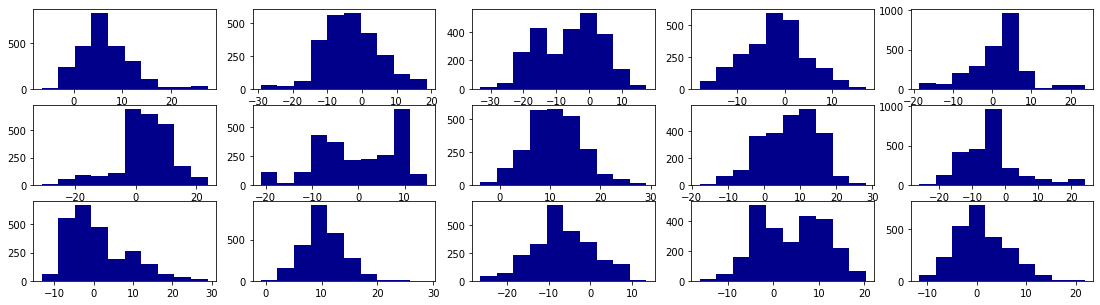

In [198]:
plt.figure(figsize=(19,5))
for i in range(encoded_X.detach().shape[1]):

  pl_data = encoded_X[:,i]
  plt.subplot(3,5,i+1)
  _ = plt.hist(pl_data.detach(), color = ["darkblue"])

In [199]:
encoded_X.max(), encoded_X.min()

(tensor(29.1329, grad_fn=<MaxBackward1>),
 tensor(-33.1246, grad_fn=<MinBackward1>))

In [200]:
encoded_data = TensorDataset(encoded_X, y[np.where(y==0)])

## GAN

In [201]:
class Discriminator(nn.Module):
  def __init__(self, data_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(data_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, data_dim),
        nn.BatchNorm1d(data_dim)
    )

  def forward(self, x):
    return self.gen(x)


In [202]:
lr = 1e-3
z_dim = 64 #hyperparameter
data_dim = 15
batch_size = 32
num_epochs = 50

In [203]:
encoded_data = DataLoader(encoded_data, batch_size=batch_size)

In [204]:
disc = Discriminator(data_dim)
gen = Generator(z_dim, data_dim)
fixed_noise = torch.randn((batch_size, z_dim))
opt_disc = torch.optim.Adam(disc.parameters(), lr = lr)
opt_gen = torch.optim.Adam(gen.parameters(), lr = lr)
criterion = nn.BCELoss()

In [205]:
losses_Gen = []
losses_Disc = []
losses_Fake = []
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(encoded_data):
    #Train Discriminator: maximing function
    noise = torch.randn(batch_size, z_dim)
    fake = gen(noise)
    disc_real = disc(real)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    lossD.backward(retain_graph = True)
    opt_disc.step()

    #Train Generator: minimizing function
    output = disc(fake)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()
    
    if batch_idx == 0:
      print(
          f"Epoch [{epoch+1}/{num_epochs}] \ "
          f"Loss D:{lossD:.4f}(Real:{lossD_real:.4f}, Fake:{lossD_fake:.4f}) | Loss G:{lossG:.4f}"
      ) 
  losses_Disc.append(lossD)
  losses_Gen.append(lossG)
  losses_Fake.append(lossD_fake)

Epoch [1/50] \ Loss D:0.7069(Real:0.7834, Fake:0.6304) | Loss G:0.7752
Epoch [2/50] \ Loss D:0.5429(Real:0.5287, Fake:0.5571) | Loss G:0.8817
Epoch [3/50] \ Loss D:0.4012(Real:0.3936, Fake:0.4088) | Loss G:1.2031
Epoch [4/50] \ Loss D:0.3201(Real:0.3171, Fake:0.3232) | Loss G:1.4335
Epoch [5/50] \ Loss D:0.3127(Real:0.3192, Fake:0.3062) | Loss G:1.5635
Epoch [6/50] \ Loss D:0.2975(Real:0.2984, Fake:0.2966) | Loss G:1.6808
Epoch [7/50] \ Loss D:0.2931(Real:0.1973, Fake:0.3889) | Loss G:1.6771
Epoch [8/50] \ Loss D:0.2234(Real:0.2143, Fake:0.2324) | Loss G:1.8332
Epoch [9/50] \ Loss D:0.2258(Real:0.2026, Fake:0.2491) | Loss G:1.9963
Epoch [10/50] \ Loss D:0.2468(Real:0.1875, Fake:0.3062) | Loss G:1.7628
Epoch [11/50] \ Loss D:0.2346(Real:0.1914, Fake:0.2777) | Loss G:1.8742
Epoch [12/50] \ Loss D:0.2457(Real:0.1942, Fake:0.2973) | Loss G:1.9368
Epoch [13/50] \ Loss D:0.2240(Real:0.1851, Fake:0.2628) | Loss G:1.9304
Epoch [14/50] \ Loss D:0.2143(Real:0.1908, Fake:0.2378) | Loss G:2.2242
E

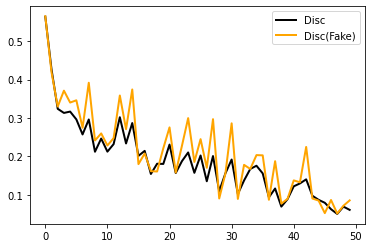

In [206]:
plt.plot(losses_Disc, c = "black", linewidth=2)
plt.plot(losses_Fake, c = "orange", linewidth=2)
plt.legend(['Disc', 'Disc(Fake)'])

## Outputs of discriminator for the last batch
**value << 0.5** means that the discriminator can identify fakes.

**value =~ 0.5** indicates that the discriminator's accuracy is 50% and now it's identifying fakes based on a flip of coin

In [207]:
print(f"Discriminator error {output.mean().item():.4f}")

Discriminator error 0.0662


In [208]:
outputs = []
samples = []
gen.eval()
disc.eval()
with torch.no_grad():
  out = gen(torch.randn(yes-no, z_dim))
  disc_targ = disc(out)
  disc_targ = disc_targ
  outputs.append(list(disc_targ.detach()))
  samples.append(out)

In [209]:
outputs = np.round(np.array(outputs))

In [210]:
zero = np.where(np.array(outputs) == 0)
ones = np.where(np.array(outputs) == 1)

In [211]:
len(ones[0])/(len(ones[0])+len(zero[0]))

0.3247863247863248

In [212]:
encoded_X = torch.cat((X,samples[0])).detach()
y = torch.cat((y,torch.zeros(yes-no))).detach()

In [213]:
y.shape, encoded_X.shape

(torch.Size([5444]), torch.Size([5444, 15]))

In [214]:
encoded_X.min(), encoded_X.max()

(tensor(-34.5730), tensor(35.0022))

## MLP Classifier on encoded data

In [215]:
# Dividing data into training, testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.6, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

In [216]:
from sklearn.neural_network import MLPClassifier

#LBFGS is the optimizer, which works relatively better when applied on 
#smaller datasets because it's a local search algorithm
clf = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(15,2), random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15, 2), random_state=1)

In [217]:
y_pred = clf.predict(X_test)
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

In [218]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn=cm[0][0] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[1][1] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

Test accuracy is:0.9513
Precision: 0.9624 Recall: 0.9409


In [219]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Average CV Score: ',scores.mean())
scores

Average CV Score:  0.9521212759237814


array([0.94927536, 0.96135266, 0.9589372 , 0.94673123, 0.94430993])

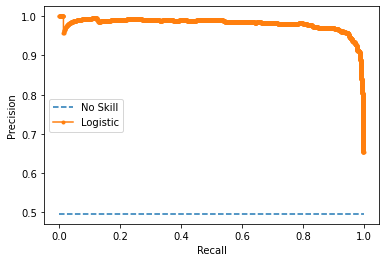

F1: 0.9515096065873742
AUC: 0.9808129818748329
Accuracy 0.9513314967860422


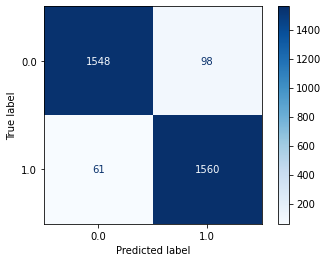

In [220]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, y_pred)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print("F1:",lr_f1)
print("AUC:",lr_auc)
print("Accuracy",acc)

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="Blues")